In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/cryptocurrencyclosingpriceprediction/StarterNotebook.ipynb
/kaggle/input/cryptocurrencyclosingpriceprediction/SampleSubmission.csv
/kaggle/input/cryptocurrencyclosingpriceprediction/Train.csv
/kaggle/input/cryptocurrencyclosingpriceprediction/Test.csv


In [2]:
train = pd.read_csv('/kaggle/input/cryptocurrencyclosingpriceprediction/Train.csv')
test = pd.read_csv('/kaggle/input/cryptocurrencyclosingpriceprediction/Test.csv')

train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

train.shape,test.shape

((12632, 49), (6222, 48))

In [3]:
train['H-L'] = train.apply(lambda x: np.abs(x['high'] - x['low']),axis=1)
train['m_cap_bin'] = pd.cut(train['market_cap'],10,labels=False)

In [4]:
test['H-L'] = test.apply(lambda x: np.abs(x['high'] - x['low']),axis=1)
test['m_cap_bin'] = pd.cut(test['market_cap'],10,labels=False)

In [5]:
#features = [c for c in test.columns[2:]]
features = ['open', 'high', 'low', 'market_cap', 'market_cap_global']
target = ['close']

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(train[features], train[target])
features_selected = selector.support_

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_rfe.py:231: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y)


In [7]:
new_features = list(np.array(features)[features_selected])
new_features

['open', 'high', 'low', 'market_cap', 'market_cap_global']

In [8]:
new_features = features

In [9]:
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits=5,shuffle=True,random_state=2021)

for fold,(trn_indx,test_indx) in enumerate(kf.split(train[new_features],train[target])):
    train.loc[test_indx,'fold'] = fold + 1
    

In [10]:
l1_preds = np.zeros(shape=(len(test),1))
rmse_folds = []


for fold in range(5):
    X_train,X_test = train.loc[train.fold!=fold+1,new_features],train.loc[train.fold==fold+1,new_features]
    y_train,y_test = train.loc[train.fold!=fold+1,target],train.loc[train.fold==fold+1,target]
    reg = make_pipeline(StandardScaler(),LinearRegression())
    reg.fit(X_train,y_train.values.reshape(-1,1))
    train.loc[train.fold==fold+1,'l1_preds'] = reg.predict(train.loc[train.fold==fold+1,new_features])
    rmse_folds.append(np.sqrt(mean_squared_error(train.loc[train.fold==fold+1,target],train.loc[train.fold==fold+1,'l1_preds'])))
    l1_preds += reg.predict(test[new_features]).reshape(-1,1)

test['l1_preds'] = l1_preds/5
print("Average RMSE",np.array(rmse_folds).mean())

Average RMSE 57.588727493883354


In [11]:
train.head()

,id,asset_id,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,...,medium,youtube,social_volume,percent_change_24h,market_cap_global,close,H-L,m_cap_bin,fold,l1_preds
0,ID_322qz6,1,9422.849081,9428.490628,9422.849081,7.131986e+08,1.737635e+11,1689.0,817.0,55.0,...,2.0,5.0,4422,1.434516,2.818066e+11,9428.279323,5.641547,1,2.0,9424.711768
1,ID_3239o9,1,7985.359278,7992.059917,7967.567267,4.004755e+08,1.426942e+11,920.0,544.0,20.0,...,0.0,0.0,2159,-2.459507,2.126897e+11,7967.567267,24.492650,1,2.0,7974.951404
2,ID_323J9k,1,49202.033778,49394.593518,49068.057046,3.017729e+09,9.166977e+11,1446.0,975.0,72.0,...,0.0,0.0,10602,4.942448,1.530712e+12,49120.738484,326.536472,8,5.0,49242.402802
3,ID_323y5P,1,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,17.0,...,0.0,0.0,285,0.000000,0.000000e+00,0.000000,0.000000,0,3.0,5.395497
4,ID_324kJH,1,10535.737119,10535.737119,10384.798216,1.150053e+09,1.921183e+11,1012.0,638.0,24.0,...,0.0,2.0,3996,2.609576,3.386925e+11,10384.798216,150.938903,1,4.0,10433.966090


In [12]:
new_features = list(new_features) + ['l1_preds']
new_features

['open', 'high', 'low', 'market_cap', 'market_cap_global', 'l1_preds']

In [13]:
l2_preds = np.zeros(shape=(len(test),1))
rmse_folds = []

for fold in range(5):
    X_train,X_test = train.loc[train.fold!=fold+1,new_features],train.loc[train.fold==fold+1,new_features]
    y_train,y_test = train.loc[train.fold!=fold+1,target],train.loc[train.fold==fold+1,target]
    reg = lgb.LGBMRegressor()
    reg.fit(X_train,y_train.values.reshape(-1,1))
    train.loc[train.fold==fold+1,'l2_preds'] = reg.predict(train.loc[train.fold==fold+1,new_features])
    rmse_folds.append(np.sqrt(mean_squared_error(train.loc[train.fold==fold+1,target],train.loc[train.fold==fold+1,'l2_preds'])))
    l2_preds += reg.predict(test[new_features]).reshape(-1,1)

test['l2_preds'] = l2_preds/5
print("Average RMSE",np.array(rmse_folds).mean())

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Average RMSE 108.9492059169872


Feature: 0, Score: 589.00000
Feature: 1, Score: 385.00000
Feature: 2, Score: 385.00000
Feature: 3, Score: 558.00000
Feature: 4, Score: 582.00000
Feature: 5, Score: 501.00000


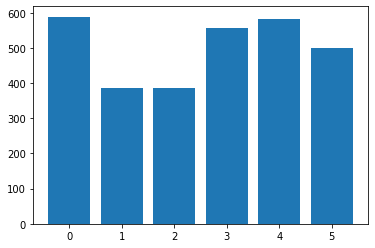

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

importance = reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [15]:
new_features = list(new_features) + ['l2_preds']
new_features

['open',
 'high',
 'low',
 'market_cap',
 'market_cap_global',
 'l1_preds',
 'l2_preds']

In [16]:
l3_preds = np.zeros(shape=(len(test),1))
rmse_folds = []

for fold in range(5):
    X_train,X_test = train.loc[train.fold!=fold+1,new_features],train.loc[train.fold==fold+1,new_features]
    y_train,y_test = train.loc[train.fold!=fold+1,target],train.loc[train.fold==fold+1,target]
    reg = RandomForestRegressor()
    reg.fit(X_train,y_train.values.reshape(-1,1))
    train.loc[train.fold==fold+1,'l3_preds'] = reg.predict(train.loc[train.fold==fold+1,new_features])
    rmse_folds.append(np.sqrt(mean_squared_error(train.loc[train.fold==fold+1,target],train.loc[train.fold==fold+1,'l3_preds'])))
    l3_preds += reg.predict(test[new_features]).reshape(-1,1)

test['l3_preds'] = l3_preds/5
print("Average RMSE",np.array(rmse_folds).mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was pas

Average RMSE 51.66627824711761


In [20]:
l3_preds = np.where(l3_preds<0,0,l3_preds)

In [21]:
test['close'] = l3_preds / 5
test[['id','close']].head()

,id,close
0,ID_323Sn2,0.000000
1,ID_325SNW,11347.292865
2,ID_325uzE,6314.043493
3,ID_328qCx,0.000000
4,ID_3293uJ,0.000000


In [22]:
test[['id','close']].to_csv('sub20.csv',index=False)